In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
INPUT_DIR = '/content/drive/MyDrive/atmaCup/#11/dataset_atmaCup11'

materials = pd.read_csv(os.path.join(INPUT_DIR, "materials.csv"))
techniques = pd.read_csv(os.path.join(INPUT_DIR, "techniques.csv"))
train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))

In [3]:
materials['name'].unique()

array(['ink', 'paper', 'pencil', 'watercolor (paint)', 'chalk',
       'paint (coating)', 'gouache (paint)', 'deck paint',
       'prepared paper', 'parchment (animal material)',
       'graphite (mineral)', 'tracing paper', 'cardboard',
       'oil paint (paint)', 'linen (material)', 'leather', 'metal',
       'zinc', 'bristol board', 'varnish', 'palm leaf (material)',
       'gold leaf', 'India ink (ink)', 'velvet (fabric weave)',
       'wood (plant material)'], dtype=object)

In [4]:
techniques['name'].unique()

array(['pen', 'brush', 'counterproof', 'pencil', 'snipping', 'chalk',
       'engraving', 'sewing', 'letterpress printing', 'scoring'],
      dtype=object)

textheroによるデータの前処理

In [5]:
!pip install texthero

In [6]:
import texthero as hero

In [7]:
raw_text = materials['name']

clean_text = hero.clean(raw_text, pipeline=[
    hero.preprocessing.fillna,
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_digits,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_diacritics,
    hero.preprocessing.remove_stopwords
])

In [8]:
raw_text[raw_text != clean_text].unique()

array(['watercolor (paint)', 'paint (coating)', 'gouache (paint)',
       'parchment (animal material)', 'graphite (mineral)',
       'oil paint (paint)', 'linen (material)', 'palm leaf (material)',
       'India ink (ink)', 'velvet (fabric weave)',
       'wood (plant material)'], dtype=object)

In [9]:
clean_text[raw_text != clean_text].unique()

array(['watercolor  paint ', 'paint  coating ', 'gouache  paint ',
       'parchment  animal material ', 'graphite  mineral ',
       'oil paint  paint ', 'linen  material ', 'palm leaf  material ',
       'india ink  ink ', 'velvet  fabric weave ',
       'wood  plant material '], dtype=object)

In [10]:
materials['name'] = clean_text
materials.head()

,name,object_id
0,ink,002bff09b09998d0be65
1,paper,002bff09b09998d0be65
2,pencil,002bff09b09998d0be65
3,watercolor paint,00309fb1ef05416f9c1f
4,paper,00309fb1ef05416f9c1f


In [11]:
new_materials = materials.groupby('object_id')['name'].agg({lambda x: ' '.join(x)})
new_materials.columns = ['materials']
new_materials = new_materials.reset_index()
new_materials.head()

,object_id,materials
0,002bff09b09998d0be65,ink paper pencil
1,00309fb1ef05416f9c1f,watercolor paint paper
2,003a1562e97f79ba96dc,pencil paper
3,004890880e8e7431147b,chalk paper
4,00718c32602425f504c1,paper chalk


BERTを使ったベクトル化

In [12]:
BERT_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "bert-base-uncased",
    "bert-large-uncased",
    "bert-base-cased",
    "bert-large-cased",
    "bert-base-multilingual-uncased",
    "bert-base-multilingual-cased",
    "bert-base-chinese",
    "bert-base-german-cased",
    "bert-large-uncased-whole-word-masking",
    "bert-large-cased-whole-word-masking",
    "bert-large-uncased-whole-word-masking-finetuned-squad",
    "bert-large-cased-whole-word-masking-finetuned-squad",
    "bert-base-cased-finetuned-mrpc",
    "bert-base-german-dbmdz-cased",
    "bert-base-german-dbmdz-uncased",
    "cl-tohoku/bert-base-japanese",
    "cl-tohoku/bert-base-japanese-whole-word-masking",
    "cl-tohoku/bert-base-japanese-char",
    "cl-tohoku/bert-base-japanese-char-whole-word-masking",
    "TurkuNLP/bert-base-finnish-cased-v1",
    "TurkuNLP/bert-base-finnish-uncased-v1",
    "wietsedv/bert-base-dutch-cased",
    # See all BERT models at https://huggingface.co/models?filter=bert
]

In [13]:
# transformers というライブラリに入ってる BERT を使用します
!pip install transformers > /dev/null

import pandas as pd
import numpy as np
import torch
import transformers

from transformers import BertTokenizer
from tqdm import tqdm
tqdm.pandas()


class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-cased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [14]:
BSV = BertSequenceVectorizer() # インスタンス化します

new_materials['materials_feature'] = new_materials['materials'].progress_apply(lambda x: BSV.vectorize(x))
new_materials[['object_id', 'materials', 'materials_feature']].head()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3936/3936 [00:42<00:00, 91.59it/s]


,object_id,materials,materials_feature
0,002bff09b09998d0be65,ink paper pencil,"[0.19435495, -0.06401093, -0.19383787, -0.2417..."
1,00309fb1ef05416f9c1f,watercolor paint paper,"[0.06848554, -0.1759471, -0.27907047, -0.45445..."
2,003a1562e97f79ba96dc,pencil paper,"[0.2364887, -0.05671821, -0.100548, -0.4266412..."
3,004890880e8e7431147b,chalk paper,"[0.18883155, -0.22086279, -0.12459577, -0.5079..."
4,00718c32602425f504c1,paper chalk,"[0.14096169, -0.21260877, -0.23347606, -0.3914..."


In [15]:
new_materials.shape

(3936, 3)

In [16]:
def create_input_array_pca(input_df):
    features = []
    for array in input_df['materials_feature']:
        features.append(array)
    return pd.DataFrame(features).values.astype(np.float32)
    
materials_feature_df = new_materials[['materials_feature']].copy()
x = create_input_array_pca(materials_feature_df)

In [17]:
from sklearn.decomposition import PCA
def result_materials_pca(N):
    pca = PCA(n_components=N).fit(x)
    transformed = pca.transform(x)
    for n in range(N):
        print(f'第 {n+1} 主成分：{pca.explained_variance_ratio_[n]}')
    return pd.DataFrame(transformed).add_prefix('BERT_materials_')

In [18]:
result_feature = result_materials_pca(2)
new_materials = pd.concat([new_materials, result_feature], axis=1)
new_materials.head()

第 1 主成分：0.2642410397529602
第 2 主成分：0.13373562693595886


,object_id,materials,materials_feature,BERT_materials_0,BERT_materials_1
0,002bff09b09998d0be65,ink paper pencil,"[0.19435495, -0.06401093, -0.19383787, -0.2417...",-0.284742,2.005033
1,00309fb1ef05416f9c1f,watercolor paint paper,"[0.06848554, -0.1759471, -0.27907047, -0.45445...",3.332900,0.422984
2,003a1562e97f79ba96dc,pencil paper,"[0.2364887, -0.05671821, -0.100548, -0.4266412...",-0.638981,0.601327
3,004890880e8e7431147b,chalk paper,"[0.18883155, -0.22086279, -0.12459577, -0.5079...",-2.449574,-1.161013
4,00718c32602425f504c1,paper chalk,"[0.14096169, -0.21260877, -0.23347606, -0.3914...",-1.513793,-1.077737


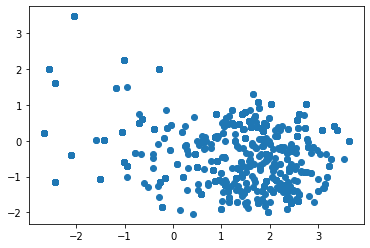

In [20]:
plt.scatter(new_materials['BERT_materials_0'], new_materials['BERT_materials_1']);

In [27]:
new_materials = new_materials.drop(['materials', 'materials_feature'],axis=1)
new_materials

,object_id,BERT_materials_0,BERT_materials_1
0,002bff09b09998d0be65,-0.284742,2.005033
1,00309fb1ef05416f9c1f,3.332900,0.422984
2,003a1562e97f79ba96dc,-0.638981,0.601327
3,004890880e8e7431147b,-2.449574,-1.161013
4,00718c32602425f504c1,-1.513793,-1.077737
...,...,...,...
3931,ffa3259fff8e6f3818a1,2.607312,0.752130
3932,ffd4d361756587883e48,-2.056948,3.480807
3933,ffd794b7b311b7b7fd92,1.021997,0.510875
3934,ffe49bba69d06446de7e,0.594065,-0.039455


In [28]:
new_materials.to_csv(os.path.join(INPUT_DIR, 'BERT_materials.csv'), index=False)

In [40]:
new_techniques = materials.groupby('object_id')['name'].agg({lambda x: ' '.join(x)})
new_techniques.columns = ['techniques']
new_techniques = new_techniques.reset_index()
new_techniques.head()

,object_id,techniques
0,002bff09b09998d0be65,ink paper pencil
1,00309fb1ef05416f9c1f,watercolor paint paper
2,003a1562e97f79ba96dc,pencil paper
3,004890880e8e7431147b,chalk paper
4,00718c32602425f504c1,paper chalk


In [41]:
BSV = BertSequenceVectorizer()

new_techniques['techniques_feature'] = new_techniques['techniques'].progress_apply(lambda x: BSV.vectorize(x))
new_techniques[['object_id', 'techniques', 'techniques_feature']].head()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3936/3936 [00:43<00:00, 89.67it/s]


,object_id,techniques,techniques_feature
0,002bff09b09998d0be65,ink paper pencil,"[0.19435495, -0.06401093, -0.19383787, -0.2417..."
1,00309fb1ef05416f9c1f,watercolor paint paper,"[0.06848554, -0.1759471, -0.27907047, -0.45445..."
2,003a1562e97f79ba96dc,pencil paper,"[0.2364887, -0.05671821, -0.100548, -0.4266412..."
3,004890880e8e7431147b,chalk paper,"[0.18883155, -0.22086279, -0.12459577, -0.5079..."
4,00718c32602425f504c1,paper chalk,"[0.14096169, -0.21260877, -0.23347606, -0.3914..."


In [42]:
def create_input_array_pca(input_df):
    features = []
    for array in input_df['techniques_feature']:
        features.append(array)
    return pd.DataFrame(features).values.astype(np.float32)
    
techniques_feature_df = new_techniques[['techniques_feature']].copy()
x = create_input_array_pca(techniques_feature_df)

In [43]:
from sklearn.decomposition import PCA
def result_techniques_pca(N):
    pca = PCA(n_components=N).fit(x)
    transformed = pca.transform(x)
    for n in range(N):
        print(f'第 {n+1} 主成分：{pca.explained_variance_ratio_[n]}')
    return pd.DataFrame(transformed).add_prefix('BERT_techniques_')

In [44]:
result_feature = result_techniques_pca(2)
new_techniques = pd.concat([new_techniques, result_feature], axis=1)
new_techniques.head()

第 1 主成分：0.26424115896224976
第 2 主成分：0.13373570144176483


,object_id,techniques,techniques_feature,BERT_techniques_0,BERT_techniques_1
0,002bff09b09998d0be65,ink paper pencil,"[0.19435495, -0.06401093, -0.19383787, -0.2417...",-0.284740,2.005031
1,00309fb1ef05416f9c1f,watercolor paint paper,"[0.06848554, -0.1759471, -0.27907047, -0.45445...",3.332902,0.422976
2,003a1562e97f79ba96dc,pencil paper,"[0.2364887, -0.05671821, -0.100548, -0.4266412...",-0.638981,0.601329
3,004890880e8e7431147b,chalk paper,"[0.18883155, -0.22086279, -0.12459577, -0.5079...",-2.449574,-1.161011
4,00718c32602425f504c1,paper chalk,"[0.14096169, -0.21260877, -0.23347606, -0.3914...",-1.513794,-1.077737


In [45]:
new_techniques.shape

(3936, 5)

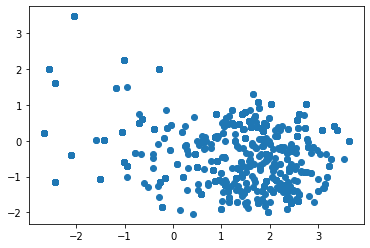

In [46]:
plt.scatter(new_techniques['BERT_techniques_0'], new_techniques['BERT_techniques_1']);

In [48]:
new_techniques = new_techniques.drop(['techniques_feature', 'techniques'],axis=1)
new_techniques

,object_id,BERT_techniques_0,BERT_techniques_1
0,002bff09b09998d0be65,-0.284740,2.005031
1,00309fb1ef05416f9c1f,3.332902,0.422976
2,003a1562e97f79ba96dc,-0.638981,0.601329
3,004890880e8e7431147b,-2.449574,-1.161011
4,00718c32602425f504c1,-1.513794,-1.077737
...,...,...,...
3931,ffa3259fff8e6f3818a1,2.607315,0.752118
3932,ffd4d361756587883e48,-2.056945,3.480808
3933,ffd794b7b311b7b7fd92,1.022000,0.510864
3934,ffe49bba69d06446de7e,0.594065,-0.039452


In [49]:
new_techniques.to_csv(os.path.join(INPUT_DIR, 'BERT_techniques.csv'), index=False)